# Ames Housing Regression

## 1. Imports & Setup

In [20]:
# Core
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## 2. Load dataset

In [21]:
df = pd.read_csv("AmesHousing.csv")
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


The dataset has 82 features, a mix of categorical and numerical.

Target Value: `SalePrice`

## Exploratory Data Analysis (EDA)

- The dataset contains **82 features** (mix of numerical and categorical).
- Many features have missing values, especially `Alley`, `PoolQC`, `Fence`, and `MiscFeature`.
- Target variable (`SalePrice`) is **right-skewed** → log-transforming may help models.
- From correlation analysis:
  - `OverallQual` (quality of the house) shows the **strongest positive correlation** with `SalePrice`.
  - `GrLivArea` (above-ground living area) is also highly correlated.
  - `GarageCars` and `TotalBsmtSF` are moderately correlated.
  - Features like `YrSold` or `MiscVal` show little to no correlation.
  
These correlations suggest that house size, quality, and garage space are key drivers of price.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

<Axes: >

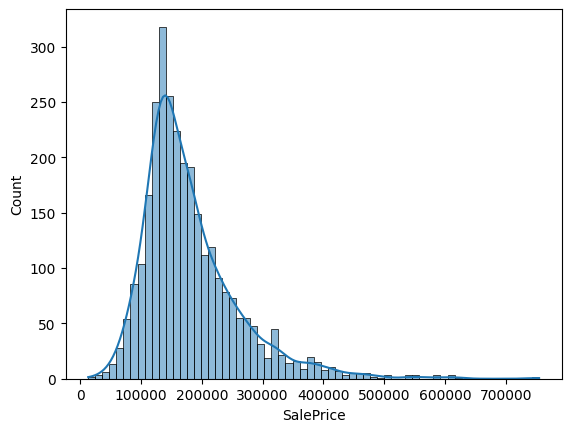

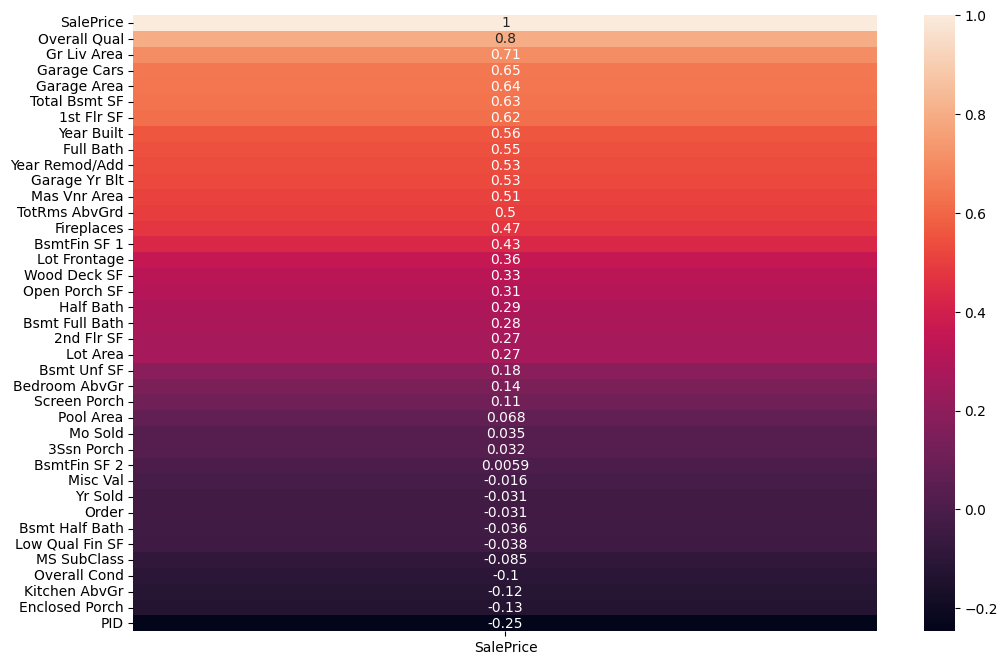

In [22]:
df.info()
df.describe()

# Missing values
df.isnull().sum().sort_values(ascending=False).head(20)

# Target distribution
sns.histplot(df["SalePrice"], kde=True)

# Correlation heatmap (numerical features only)
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True)["SalePrice"].sort_values(ascending=False).to_frame(), annot=True)

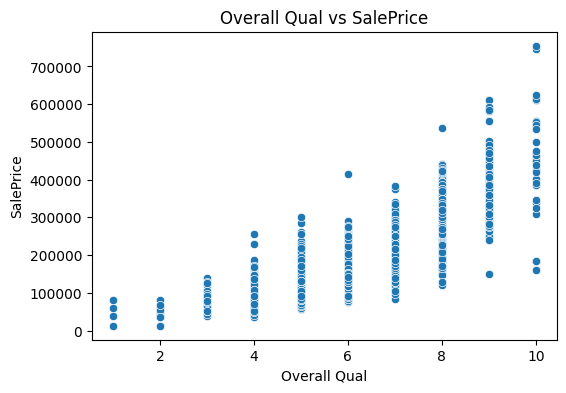

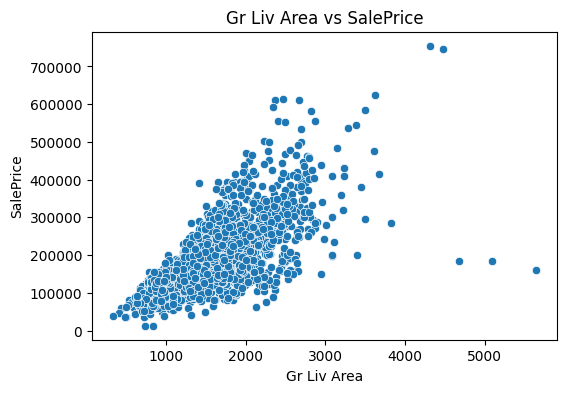

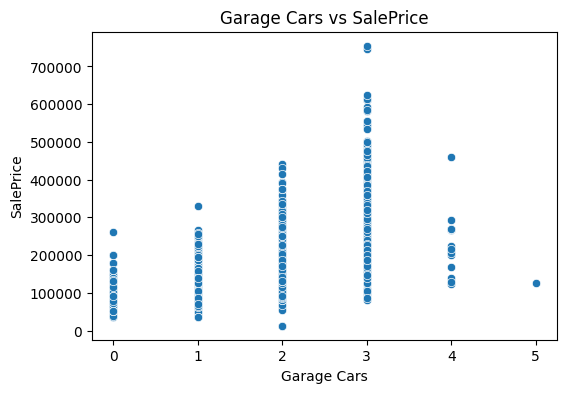

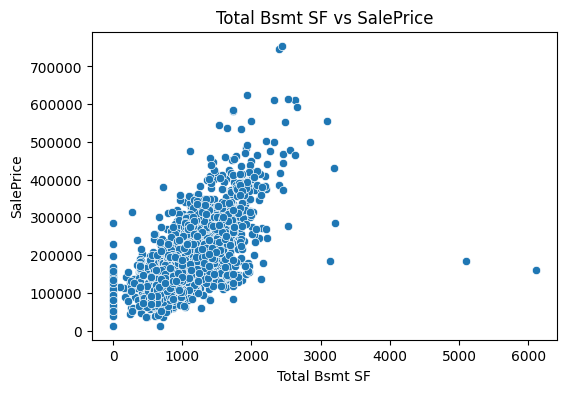

In [31]:
# Scatterplots of top correlated features with SalePrice
top_feats = ["Overall Qual", "Gr Liv Area", "Garage Cars", "Total Bsmt SF"]
for feat in top_feats:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df[feat], y=df["SalePrice"])
    plt.title(f"{feat} vs SalePrice")
    plt.show()


## 4. Feature Engineering / Preprocessing

- Impute missing values
- Encode categoricals (OneHot or LabelEncoding)
- Scale if needed

In [23]:
# Fill missing values for numerical columns with median
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Target
y = df["SalePrice"]
x = df.drop("SalePrice", axis=1)

We dropped/encoded features based on correlation and domain knowledge.

Features like OverallQual, GrLivArea and GarageCars showed strong importance.

## 5. Train/Test split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## 6. Models

### Linear Regression

In [25]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_prediction_lr = lr.predict(X_test)

### Polynomial Features + Linear Regression

In [26]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train)
y_prediction_lr_poly = lr_poly.predict(X_test_poly)

### Random Forest

In [27]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_prediction_rf = rf.predict(X_test)

## 7. Evaluation

In [32]:
def evaluate_model(y_true, y_prediction):
    return {
        "R2": r2_score(y_true, y_prediction),
        "RMSE": mean_squared_error(y_true, y_prediction),
        "MAE": mean_absolute_error(y_true, y_prediction)
    }

results = {
    "LinearRegression": evaluate_model(y_test, y_prediction_lr),
    "PolynomialRegression": evaluate_model(y_test, y_prediction_lr_poly),
    "RandomForest": evaluate_model(y_test, y_prediction_rf)
}

results_df = pd.DataFrame(results).T.round(3)
results_df

,R2,RMSE,MAE
LinearRegression,0.896,8.341823e+08,15969.347
PolynomialRegression,0.853,1.174657e+09,18021.845
RandomForest,0.911,7.096103e+08,15918.310


### Model Performance Comparison

| Model                | R²    | RMSE        | MAE   |
|----------------------|-------|-------------|-------|
| Linear Regression    | 0.896 | 8.34e+08    | 15969 |
| Polynomial Regression| 0.853 | 1.17e+09    | 18022 |
| Random Forest        | 0.911 | 7.09e+08    | 15918 |

**Observations:**
- **Random Forest** gave the best performance overall, with the highest R² and lowest error metrics.
- **Linear Regression** was surprisingly strong as a baseline, capturing most of the linear relationships.
- **Polynomial Regression** underperformed due to overfitting and added noise from polynomial terms.
- Overall, the models show that ensemble methods handle non-linearities and interactions better.


## 8. Conclusion

- **Important features**: `OverallQual`, `GrLivArea`, `GarageCars`, and `TotalBsmtSF` were most predictive of house prices.
- **Why important?**: Strong correlations and visual patterns confirmed their importance.
- **Visualization insights**: Scatterplots revealed linear relationships for size-related features, but also highlighted outliers (e.g., very large homes with relatively low prices).
- **Unbiased test set**: Splitting into train/test was necessary to avoid data leakage and ensure fair evaluation.
- **Biases**: Data is skewed toward certain neighborhoods and higher-quality homes; this could bias predictions if deployed in the real world.
- **How to improve without new models?**
  - Better preprocessing (e.g., log-transform skewed features).
  - More careful feature engineering (interaction terms, domain knowledge).
  - Outlier removal or adjustment to reduce distortion in training.
